In [1]:
import numpy as np
import matplotlib.pyplot as plt
import contextlib as cl
import time

import readdy._internal as api
api.set_logging_level("debug")

sim = api.Simulation()
sim.set_kernel("SingleCPU")

In [2]:
sim.periodic_boundary = [True, True, True]
sim.kbt = 0.8
sim.box_size = api.Vec(60., 60., 10.)

# register particle type
particle_radius = 0.5
sim.register_particle_type("A", diffusion_coefficient=0.2, radius=particle_radius)

# the potential that confines particles
origin = np.array([-28.,-28.,-0.001])
extent = np.array([54.,54.,0.002])
sim.register_potential_box("A", 200., api.Vec(*origin), api.Vec(*extent), False)

# the pairwise interaction
sim.register_potential_piecewise_weak_interaction(
    "A", "A", force_constant=20., desired_particle_distance=2.*particle_radius, 
    depth=2.0, no_interaction_distance=4.*particle_radius
)

# add particles
rnd = np.random.uniform
for i in range(200):
    pos = origin + rnd(size=3) * extent
    sim.add_particle("A", api.Vec(*pos))

In [3]:
# define observables and run
traj_handle = sim.register_observable_flat_trajectory(stride=10)

particles_data = []
def get_particles(x):
    global particles_data
    particles_data.append(x)

handle = sim.register_observable_particles(stride=100, callback=get_particles)
    
with cl.closing(api.File("./obs.h5", api.FileAction.CREATE, api.FileFlag.OVERWRITE)) as f:
    traj_handle.enable_write_to_file(file=f, data_set_name="traj", chunk_size=10000)
    t1 = time.perf_counter()
    sim.run_scheme_readdy(True) \
        .write_config_to_file(f) \
        .with_reaction_scheduler("UncontrolledApproximation") \
        .with_skin_size(3.) \
        .configure_and_run(200000, 0.005)
    t2 = time.perf_counter()
print("Simulated", t2 - t1, "seconds")

Simulated 102.47212288100002 seconds


In [4]:
# convert trajectory
t1 = time.perf_counter()
api.convert_xyz("./obs.h5", "traj", "./traj.xyz", radii={"A": 0.5})
t2 = time.perf_counter()
print("Conversion took", t2 - t1, "seconds")

Conversion took 7.549379140000042 seconds


In [5]:
def get_msd(particles_data):
    # obtain positions and ids as numpy arrays
    positions = []
    ids = []
    for t in range(len(particles_data)):
        positions.append(
            np.array([[x[0], x[1], x[2]] for x in particles_data[t][2]])
        )
        ids.append(
            np.array([x for x in particles_data[t][1]])
        )
    positions = np.array(positions)
    ids = np.array(ids)

    # sort the positions with respect to ids in each timestep,
    # since they might have changed the index in the positions array
    sorted_positions = np.zeros_like(positions)
    for t in range(len(ids)):
        sort_indices = np.argsort(ids[t])
        sorted_positions[t] = positions[t][sort_indices]

    # calculate the actual msd
    difference = sorted_positions - sorted_positions[0]
    squared = difference * difference
    squared_deviation = np.sum(squared, axis=2)
    n_particles = sorted_positions.shape[1]
    mean_squared_deviation = np.sum(squared_deviation, axis=1) / n_particles
    return mean_squared_deviation

In [8]:
msd = get_msd(particles_data)

In [9]:
msd.shape

(2001,)

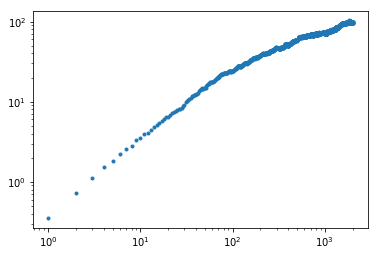

In [10]:
plt.plot(range(len(msd)), msd, ".")
plt.xscale("log")
plt.yscale("log")
plt.show()